# Text to image generation and making animations with Stable Diffusion

In this notebook, we will be looking at text to image generation with Stable Diffusion and later some different ways to make animations with text to image diffusion techniques. We will be using [kjsman's simplified (and hackable!) stable diffusion PyTorch implementation](https://github.com/kjsman/stable-diffusion-pytorch).

Next, try downloading the weights for stable diffusion with curl, if that doesn't work, just copy and paste the url directly into your browser and it will start downloading. You will need to move the file into the same folder as this notebook to run the next command.

In [15]:
# !curl -OL https://huggingface.co/jinseokim/stable-diffusion-pytorch-data/resolve/main/data.v20221029.tar

We can then unpack the following file using the following instruction.

In [16]:
# !tar -xf data.v20221029.tar

Now lets do some imports:

In [17]:
#@title Preload models (takes about ~20 seconds on default settings)
import os
import numpy as np
import IPython.display

from PIL import Image
from matplotlib.pyplot import imshow

from stable_diffusion_pytorch import pipeline
from stable_diffusion_pytorch import model_loader

%matplotlib inline
models = model_loader.preload_models('cpu')

## Generate images from text

The first task is to familiarise yourself with image generation using stable diffusion. 

To begin with we will be generating images from random noise using a text string. Experiment with different prompts and different generation parameters to familarise yourself with all of the possible ways of configuring this kind of model. 

100%|██████████| 20/20 [01:23<00:00,  4.19s/it]


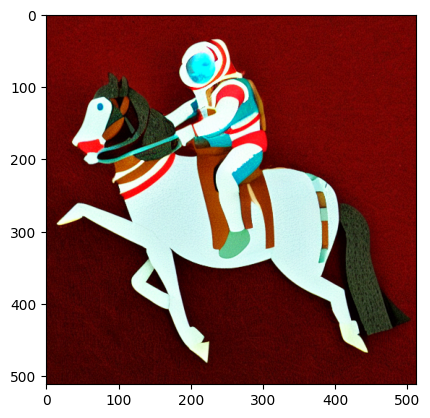

In [18]:
#Positive prompt
prompt = "an astronaut riding a horse"  #@param { type: "string" }
prompts = [prompt]

#Negative prompt
uncond_prompt = "" #@param { type: "string" }
uncond_prompts = [uncond_prompt] if uncond_prompt else None

#Generation parameters
device = 'cpu' #@param {"cpu", "cuda", "mps"]
strength = 0.8  #@param { type:"slider", min: 0, max: 1, step: 0.01 }
do_cfg = True  #@param { type: "boolean" }
cfg_scale = 7.5  #@param { type:"slider", min: 1, max: 14, step: 0.5 }
height = 512  #@param { type: "integer" }
width = 512  #@param { type: "integer" }
sampler = "k_lms"  #@param ["k_lms", "k_euler", "k_euler_ancestral"]
n_inference_steps = 20  #@param { type: "integer" }

use_seed = False  #@param { type: "boolean" }
if use_seed:
    seed = 42  #@param { type: "integer" }
else:
    seed = None

image = pipeline.generate(prompts=prompts, uncond_prompts=uncond_prompts,
                  input_images=[], strength=strength,
                  do_cfg=do_cfg, cfg_scale=cfg_scale,
                  height=height, width=width, sampler=sampler,
                  n_inference_steps=n_inference_steps, seed=seed,
                  models=models, device=device, idle_device='cpu')[0]

imshow(np.asarray(image))

## Make animations with stable diffusion


The following code block will produce a 'zooming' animation, by feeding the outputs of the diffusion model back in as inputs. First run it and inspect the code to get a feel for how it works. 

Once you have ran the code once, can you modify the previous code block to do one of more of the following:



### Using FFMPEG

If you want to make the gif animation using this code notebook you will need to install [ffmpeg](https://ffmpeg.org/download.html). We have already installed ffmpeg in week 4, so you should already have it. But if you don't, then you can follow these instructions:

To install FFMPEG on Mac:
- Step 1: [install homebrew](https://brew.sh/)
- Step 2: Run `brew install ffmpeg`

To install FFMPEG on Windows:
- Follow [these instructions](https://phoenixnap.com/kb/ffmpeg-windows) for Windows installation

To install FFMPEG on Ubuntu linux:
- Step 1: Run `sudo apt update`
- Step 2: Run `sudo apt install ffmpeg`

If you cannot install FFMPEG you can [make a gif manually using this website](https://ezgif.com/maker).



In [19]:
#Positive prompt
prompt = "Galaxies in outer space, photograph from the Hubble telescope"  #@param { type: "string" }
prompts = [prompt]

#Negative prompt
uncond_prompt = "" #@param { type: "string" }
uncond_prompts = [uncond_prompt] if uncond_prompt else None

#Parameters for generation
device = 'cpu' #@param {"cpu", "cuda", "mps"]
strength = 0.8  #@param { type:"slider", min: 0, max: 1, step: 0.01 }
do_cfg = True  #@param { type: "boolean" }
cfg_scale = 7.5  #@param { type:"slider", min: 1, max: 14, step: 0.5 }
height = 512  #@param { type: "integer" }
width = 512  #@param { type: "integer" }
sampler = "k_lms"  #@param ["k_lms", "k_euler", "k_euler_ancestral"]
n_inference_steps = 15 

crop_dim = 25 # How many pixels to crop by on each side of the image

use_seed = False  #@param { type: "boolean" }
if use_seed:
    seed = 42  #@param { type: "integer" }
else:
    seed = None

output_folder = 'animation_frames'
if not os.path.isdir(output_folder):
    os.mkdir(output_folder)

input_image_array = []
#Create a high quality initial image for the animation
init_image = pipeline.generate(prompts=prompts, uncond_prompts=uncond_prompts,
              input_images=input_image_array, strength=strength,
              do_cfg=do_cfg, cfg_scale=cfg_scale,
              height=height, width=width, sampler=sampler,
              n_inference_steps=n_inference_steps, seed=seed,
              models=models, device=device, idle_device='cpu')[0]

init_im_crop = init_image.crop((crop_dim, crop_dim, init_image.size[0] - crop_dim, init_image.size[1] - crop_dim))
# Unless you want to get experimental we probably just want to have one image in this array at any one time
input_image_array = [init_im_crop]

#Reduce the strength and number of iterations for generation the frames in the animation
strength = 0.3
cfg_scale = 3
n_inference_steps = 5 

# This block of code will recursively crop and feed in the previously generated image into the model
for i in range(10):
    image = pipeline.generate(prompts=prompts, uncond_prompts=uncond_prompts,
                      input_images=input_image_array, strength=strength,
                      do_cfg=do_cfg, cfg_scale=cfg_scale,
                      height=height, width=width, sampler=sampler,
                      n_inference_steps=n_inference_steps, seed=seed,
                      models=models, device='cpu', idle_device='cpu')[0]
    
    num_str = str(i+1).zfill(2)
    # Save generated image
    image.save(f'{output_folder}/frame_{num_str}.jpg')
    # Crop the output image
    im_crop = image.crop((crop_dim, crop_dim, image.size[0] - crop_dim, image.size[1] - crop_dim))
    # Replace image in input image array with new_image
    input_image_array = [im_crop]
    

100%|██████████| 1/1 [00:04<00:00,  4.38s/it]


Animate frames into a short gif using ffmpeg:

In [20]:
!ffmpeg -y -f image2 -framerate 4 -i 'animation_frames/frame_%02d.jpg' -loop 0 ai_animation.gif

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with clang version 12.0.0
  configuration: --prefix=/Users/ktietz/demo/mc3/conda-bld/ffmpeg_1628925491858/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=arm64-apple-darwin20.0.0-clang --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57

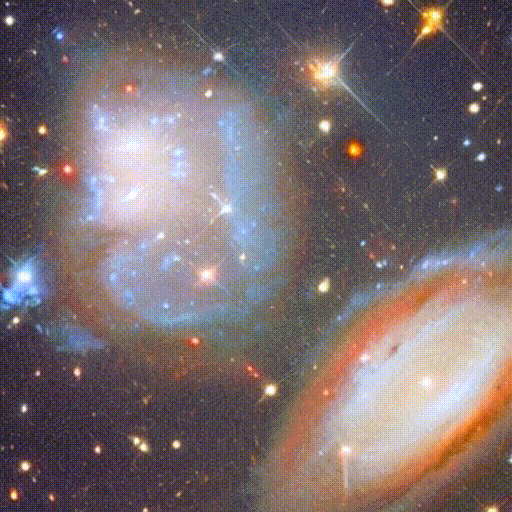

In [21]:
IPython.display.Image('ai_animation.gif')

## Reimagine an animation using stable diffusion
    
The following code block has code to modify the first frame of an animation based on a text prompt, can you modify the code to modify all 10 frames in the animation and create a new reimaging of Eadweard Muybridge's 'The horse in motion' based on your text to image prompt?

Once you have done that can you do the same thing with a different animation you have found? 

You can extract frames from a gif using: 
`ffmpeg -i input/my_animation.gif -vsync 0 frames/frame_%02d.png`

In [22]:
#Positive prompt
prompt = "an astronaut riding a horse"  #@param { type: "string" }
prompts = [prompt]

#Negative prompt
uncond_prompt = "" #@param { type: "string" }
uncond_prompts = [uncond_prompt] if uncond_prompt else None

device = 'cpu' #@param {"cpu", "cuda", "mps"]
strength = 0.8  #@param { type:"slider", min: 0, max: 1, step: 0.01 }
do_cfg = True  #@param { type: "boolean" }
cfg_scale = 7.5  #@param { type:"slider", min: 1, max: 14, step: 0.5 }
height = 512  #@param { type: "integer" }
width = 512  #@param { type: "integer" }
sampler = "k_lms"  #@param ["k_lms", "k_euler", "k_euler_ancestral"]
n_inference_steps = 10  #@param { type: "integer" }

use_seed = False  #@param { type: "boolean" }
if use_seed:
    seed = 42  #@param { type: "integer" }
else:
    seed = None

input_folder = '../media/horse-in-motion'
output_folder = 'output_animation'

if not os.path.isdir(output_folder):
    os.mkdir(output_folder)
    
for i in range(1,12):
    num_str = str(i).zfill(2)
    input_image_array = [Image.open(f'{input_folder}/frame_{num_str}.jpg')]
    image = pipeline.generate(prompts=prompts, uncond_prompts=uncond_prompts,
                    input_images=input_image_array, strength=strength,
                    do_cfg=do_cfg, cfg_scale=cfg_scale,
                    height=height, width=width, sampler=sampler,
                    n_inference_steps=n_inference_steps, seed=seed,
                    models=models, device=device, idle_device='cpu')[0]
    image.save(f'{output_folder}/frame_{num_str}.jpg')


100%|██████████| 8/8 [00:34<00:00,  4.28s/it]


You can animate the frames into a short gif using ffmpeg:

In [23]:
!ffmpeg -y -f image2 -framerate 4 -i 'output_animation/frame_%02d.jpg' -loop 0 horse_ai_animation.gif

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with clang version 12.0.0
  configuration: --prefix=/Users/ktietz/demo/mc3/conda-bld/ffmpeg_1628925491858/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=arm64-apple-darwin20.0.0-clang --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57

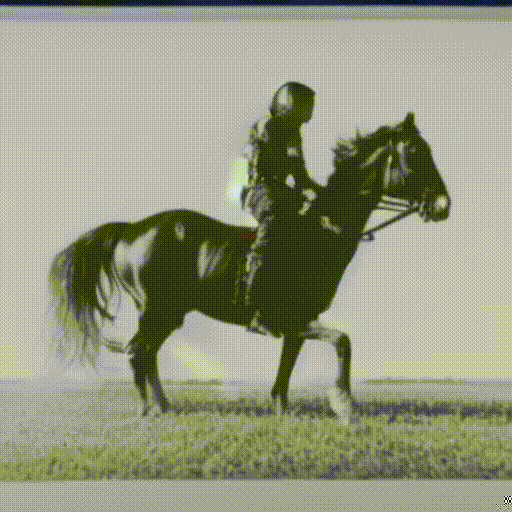

In [24]:
IPython.display.Image('horse_ai_animation.gif')

### Tasks

**Task 1:** Experiment with the settings in the [image generation cell](#generate-images-from-text). Try using different numbers of iterations for sampling, a different sampler and different config strengths to see how the effects the image generation process.

**Task 2:** Now move onto the [zooming animation cell](#make-animations-with-stable-diffusion), can you adjust the code to do any of the following:
- Make a different animation with a different prompt
- Make a longer animation 
- Improve the fidelity of the animation by adjusting the generation parameters
- Make an animation that zooms slower or more quickly
- Use an array of text prompts to make an animation that changes theme over time

**Task 3** Now lets move onto the [reimagining animation cell](#reimagine-an-animation-using-stable-diffusion). Can you load in a different gif or animation and use a diffusion model to edit that? If you have a lot of time to kill you could try extracting the frames from an mp4 video and manipulating that with stable diffusion like [some of Adam Cole's work](https://www.youtube.com/watch?v=XFHjY4_dKhI).